<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "7B"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/7B/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


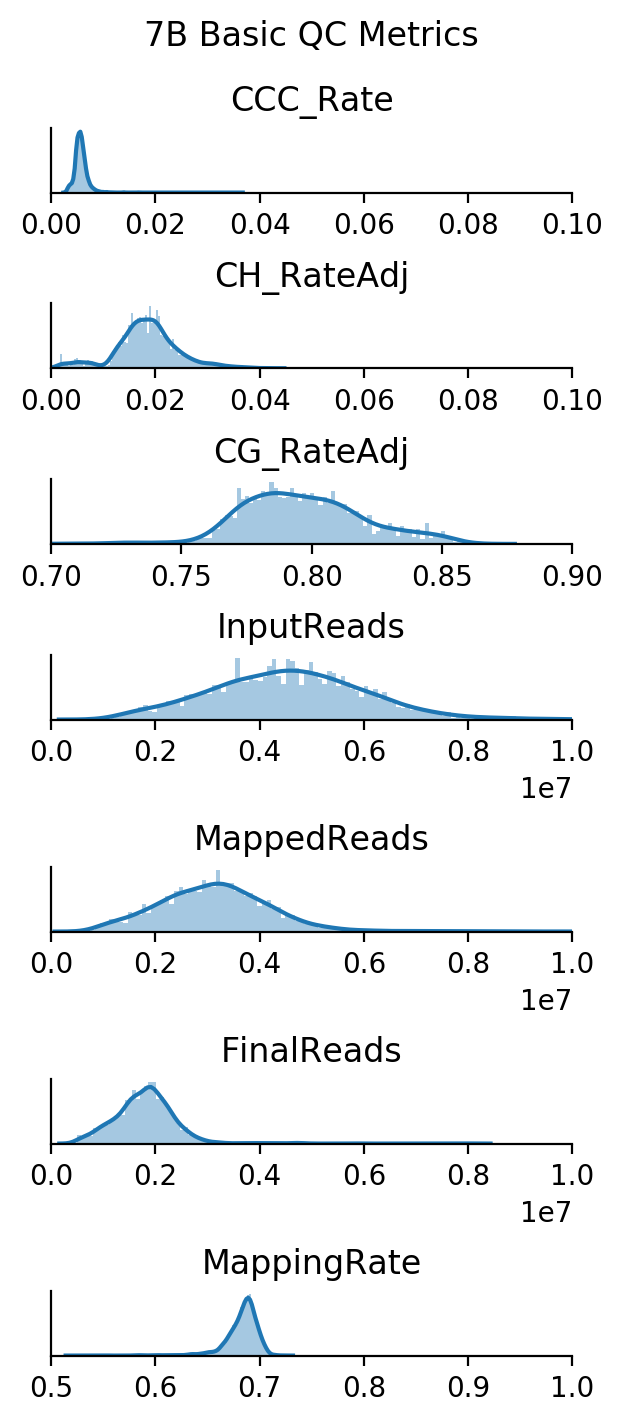

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

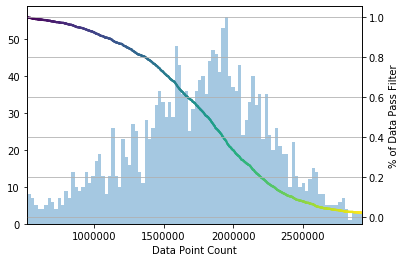

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2095/2095 (100.0%)
CG_RateAdj passed 2095/2095 (100.0%)
CH_RateAdj passed 2095/2095 (100.0%)
FinalReads passed 2095/2095 (100.0%)
MappingRate passed 2095/2095 (100.0%)
Overall passed 2095/2095 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180423 1217
180424 878


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 262 68.2%
ad002 266 69.3%
ad004 265 69.0%
ad006 263 68.5%
ad007 258 67.2%
ad008 267 69.5%
ad010 255 66.4%
ad012 259 67.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
7B_M_0,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00583,0.77958,0.77829,0.02602,0.02031,742634.0,1475238,1012044.0,7B,...,-1.217524,-14.094309,-8.170802,54.117074,IT-L23 Cux1,1.241885,10.566542,21.491988,-30.123304,True
7B_M_1,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00605,0.79135,0.79008,0.02567,0.01974,561767.0,1148152,761738.0,7B,...,-0.472595,-14.479277,2.339791,57.699599,IT-L23 Cux1,-0.893040,11.259654,8.278414,-45.901182,True
7B_M_10,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00669,0.80652,0.80522,0.02859,0.02205,1970128.0,4587512,3177288.0,7B,...,13.090758,-10.055374,25.559840,7.096022,IT-L5 Grik3,4.994417,-1.157684,7.303078,29.596013,True
7B_M_100,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00677,0.81711,0.81586,0.02832,0.02170,2176290.0,5653970,3898901.0,7B,...,24.158260,4.858600,-19.850579,-10.733244,CT-L6 Tnr,-9.220119,-22.413420,-42.205630,6.268764,True
7B_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00507,0.79363,0.79258,0.02056,0.01557,2108483.0,5770224,4003407.0,7B,...,20.653793,5.668681,-45.465648,-15.750730,CT-L6 Il1rap,-10.709324,-17.196161,16.473058,23.797644,True
7B_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00531,0.78414,0.78299,0.02200,0.01678,2380529.0,6603634,4591424.0,7B,...,-1.263059,-13.098091,-12.432460,52.172192,IT-L23 Cux1,1.195301,9.141125,16.256125,-24.462596,True
7B_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00563,0.79160,0.79042,0.02361,0.01808,2128441.0,5673140,3992706.0,7B,...,8.385188,-14.746695,8.296980,31.200277,IT-L5 Cdh8,3.381257,12.852854,0.353403,-36.630242,True
7B_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00714,0.79503,0.79356,0.03642,0.02949,1839312.0,4837748,3371604.0,7B,...,10.415864,10.846085,52.225248,26.544281,PT-L5 Nectin1,-8.413445,6.178533,19.663193,-1.385946,True
7B_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00729,0.78558,0.78401,0.03408,0.02699,2006925.0,5017972,3514211.0,7B,...,9.635383,11.313625,56.661789,24.562904,PT-L5 Kcnh1,-10.060601,9.122585,4.803402,-29.850368,True
7B_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/7B/CEMBA180423_7B...,0.00611,0.80212,0.80090,0.02726,0.02128,1983538.0,5222848,3602158.0,7B,...,23.617521,4.614418,-21.051747,-9.227347,CT-L6 Hcrtr2,-9.570971,-21.752033,-38.004311,15.508731,True
